# Packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xesmf as xe

# Initialising data

In [2]:
datapath = f'/g/data/fy29/mjl561/cylc-run/rns_ostia_2019_bushfire/netcdf'
variable = 'stratiform_rainfall_flux'
da1 = xr.open_dataset(f'{datapath}/{variable}/E5L_1_CCI_WC_{variable}.nc')[variable]
da1_local = da1.copy()
da1_local['time'] = da1['time'] + pd.Timedelta(hours=10)

In [8]:
# Open surface altitude data
variable = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable}/E5L_1_CCI_WC_{variable}.nc')[variable].isel(time=0)

In [3]:
rainfall = xr.open_dataset("/g/data/ng72/as9583/agcd_v1_precip_calib_r005_daily_2020.nc") #agcd data

### Regrid model to AGCD gridding, clip AGCD to just model domain

In [4]:
regridder = xe.Regridder(da1_local, rainfall, 'conservative')
model_total = regridder(da1_local, keep_attrs=True)

--------------------------------------------------------------------------

  Local host:   gadi-cpu-bdw-0037
  Local device: mlx5_0
--------------------------------------------------------------------------


In [6]:
model_clipped = model_total.sel(
    lat=slice(-35.5, -32.5),
    lon=slice(149, 153.5)
)

# Plots

## Regridded

### Plot model data regridded to AGCD with contours

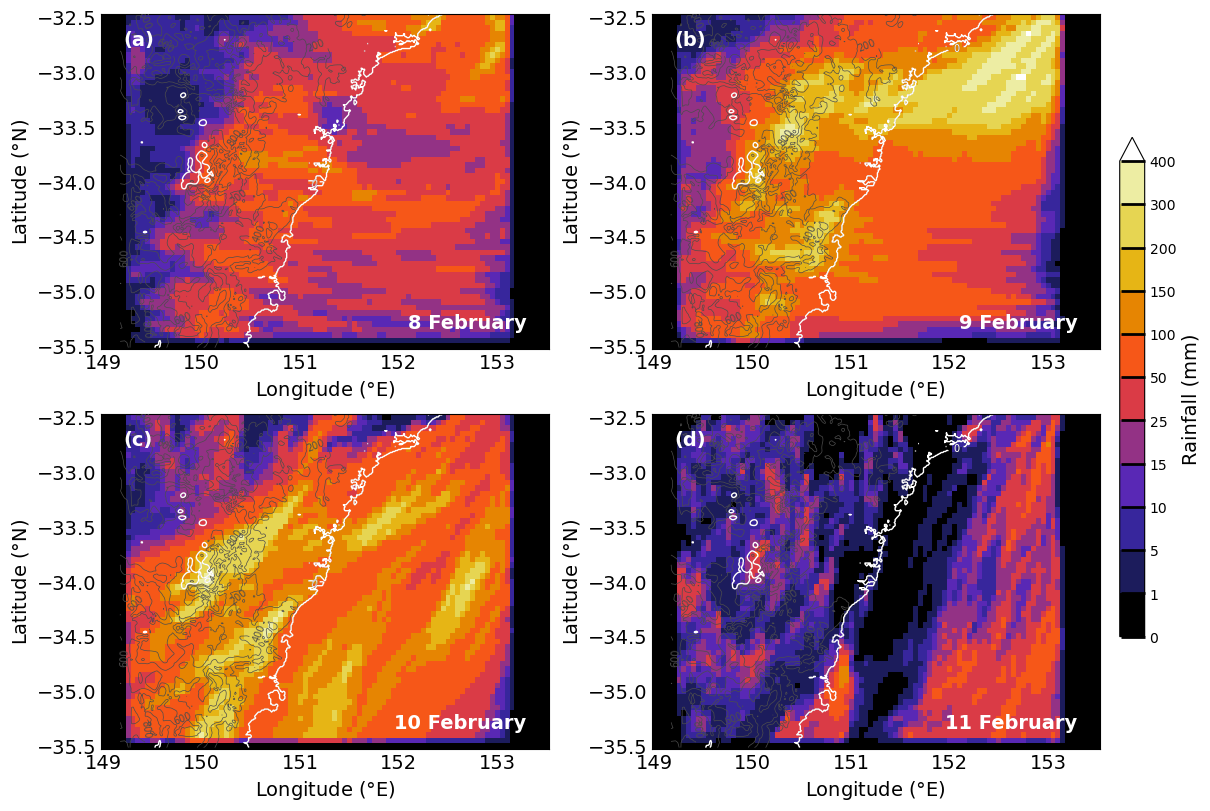

In [18]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    #9am the day before to 8am on the day
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #convert flux (mm/s) to mm/hr, then sum
    hourly = model_clipped.sel(time=slice(start_time, end_time)) * 3600  # convert to mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)

    im = daily_total.plot(
        ax=axes[i],
        cmap='CMRmap',
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    contours1 = sa1.plot.contour(
        ax=axes[i], levels=range(0, 2000, 200), colors='0.3', linewidths=0.5, add_colorbar=False
    )
    contours2 = sa1.plot.contour(
        ax=axes[i], levels=range(0, 2000, 1000), colors='white', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours1, fmt='%d', fontsize=7)
    axes[i].clabel(contours2, fmt='%d', fontsize=7)

    axes[i].set_title("")
    axes[i].text(
        0.05, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
        color='white' 
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='white' 
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)


### Cumulative over the event, regridded to AGCD

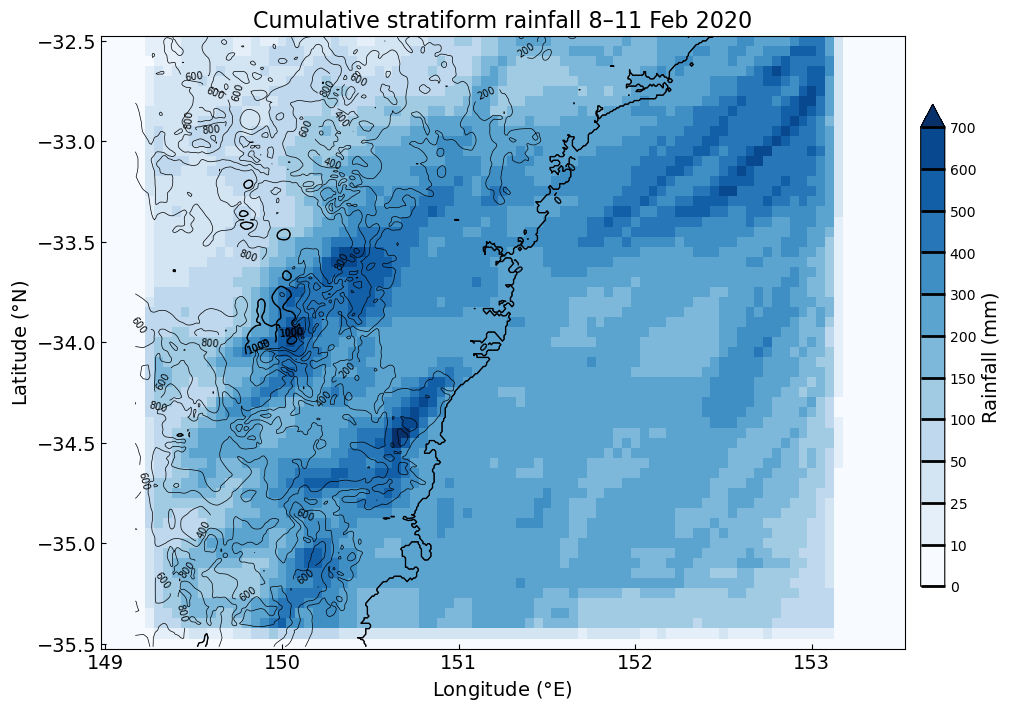

In [16]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
levels = [0, 10, 25, 50, 100, 150, 200, 300, 400, 500, 600,700]

variable = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable}/E5L_1_CCI_WC_{variable}.nc')[variable].isel(time=0)

total_precip = None

for date in dates:
    day = pd.Timestamp(date)
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #convert flux mm/s to mm/h and sum over time
    hourly = model_clipped.sel(time=slice(start_time, end_time)) * 3600
    daily_total = hourly.sum(dim='time', skipna=True)
    
    if total_precip is None:
        total_precip = daily_total
    else:
        total_precip += daily_total

fig, ax = plt.subplots(figsize=(10, 7), constrained_layout=True)

im = total_precip.plot(
    ax=ax,
    cmap='Blues',
    levels=levels,
    extend='max',
    add_colorbar=False
)

# plot contours with level texts
contours1 = sa1.plot.contour(ax=ax, levels=range(0, 2000, 200), colors='black', linewidths=0.5)
contours2 = sa1.plot.contour(ax=ax, levels=range(0, 2000, 1000), colors='black', linewidths=1)

# label contours
ax.clabel(contours1, fmt='%d', fontsize=7)
ax.clabel(contours2, fmt='%d', fontsize=7)

ax.set_title("Cumulative stratiform rainfall 8–11 Feb 2020", fontsize=16)
ax.set_xlabel("Longitude ($\\degree$E)", fontsize=14)
ax.set_ylabel("Latitude ($\\degree$N)", fontsize=14)
ax.tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)


# Original gridding data

### Cumulative over the three days, not regridded

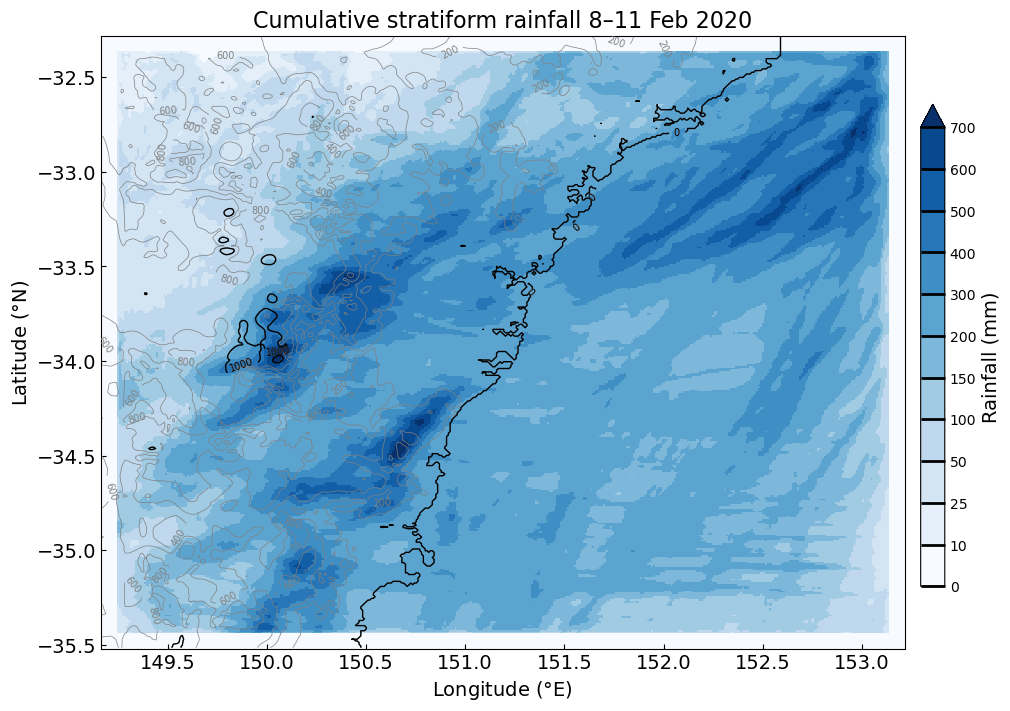

In [7]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
levels = [0, 10, 25, 50, 100, 150, 200, 300, 400, 500, 600,700]

variable = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable}/E5L_1_CCI_WC_{variable}.nc')[variable].isel(time=0)

total_precip = None

for date in dates:
    day = pd.Timestamp(date)
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #convert flux mm/s to mm/h and sum over time
    hourly = da1_local.sel(time=slice(start_time, end_time)) * 3600
    daily_total = hourly.sum(dim='time', skipna=True)
    
    if total_precip is None:
        total_precip = daily_total
    else:
        total_precip += daily_total

fig, ax = plt.subplots(figsize=(10, 7), constrained_layout=True)

im = total_precip.plot(
    ax=ax,
    cmap='Blues',
    levels=levels,
    extend='max',
    add_colorbar=False
)

# plot contours with level texts
contours1 = sa1.plot.contour(ax=ax, levels=range(0, 2000, 200), colors='0.5', linewidths=0.5)
contours2 = sa1.plot.contour(ax=ax, levels=range(0, 2000, 1000), colors='black', linewidths=1)

# label contours
ax.clabel(contours1, fmt='%d', fontsize=7)
ax.clabel(contours2, fmt='%d', fontsize=7)

ax.set_title("Cumulative stratiform rainfall 8–11 Feb 2020", fontsize=16)
ax.set_xlabel("Longitude ($\\degree$E)", fontsize=14)
ax.set_ylabel("Latitude ($\\degree$N)", fontsize=14)
ax.tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)


### Model output, no regridding 

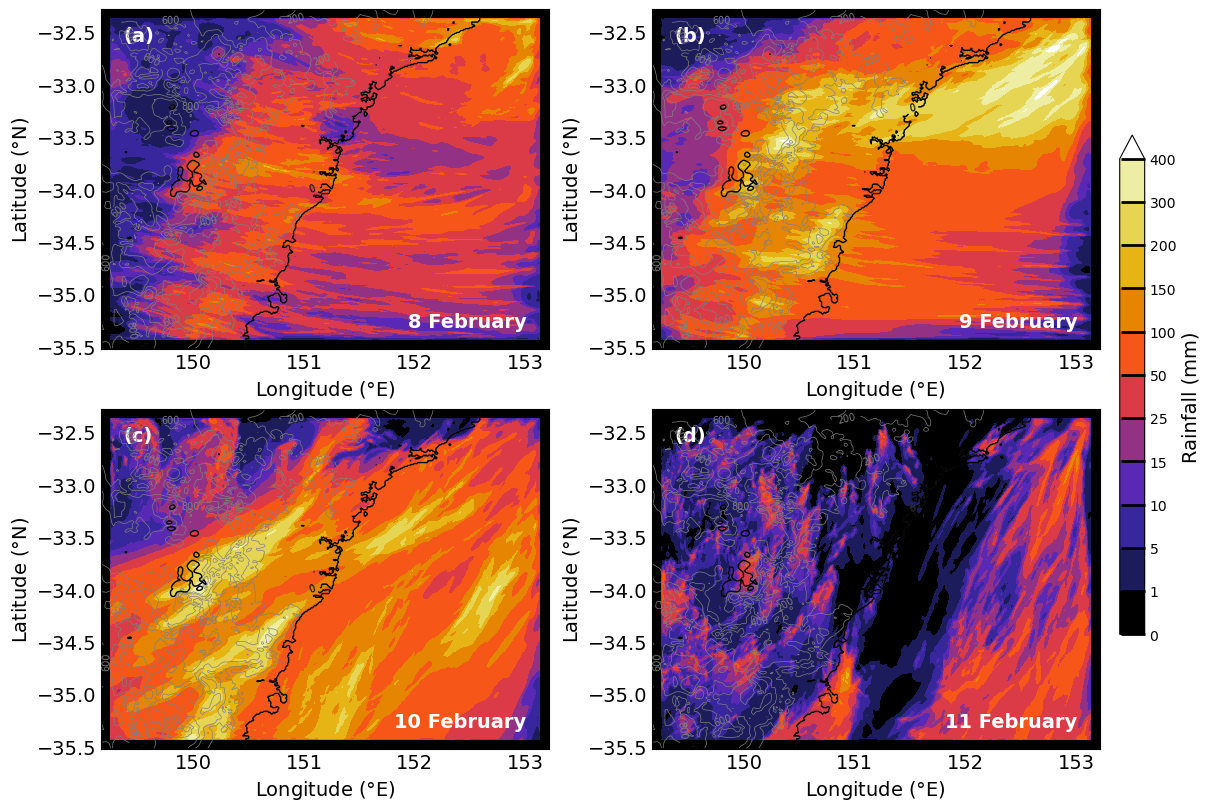

In [11]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    # 9am the day before to 8am on the day
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    # Convert flux (mm/s) to mm/hr, then sum
    hourly = da1_local.sel(time=slice(start_time, end_time)) * 3600  # mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)

    # Plot rainfall
    im = daily_total.plot(
        ax=axes[i],
        cmap='CMRmap',
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    # Overlay surface altitude contours
    contours1 = sa1.plot.contour(
        ax=axes[i], levels=range(0, 2000, 200), colors='0.5', linewidths=0.5, add_colorbar=False
    )
    contours2 = sa1.plot.contour(
        ax=axes[i], levels=range(0, 2000, 1000), colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours1, fmt='%d', fontsize=7)
    axes[i].clabel(contours2, fmt='%d', fontsize=7)

    # Annotations
    axes[i].set_title("")
    axes[i].text(
        0.05, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
        color='white'
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='white'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

# Add shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)
